In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

# 데이터로드 

In [3]:
env = pd.read_csv('/content/drive/MyDrive/DataSet/sample50/sample50_csv.csv')

In [71]:
json = pd.read_csv('/content/drive/MyDrive/DataSet/sample50/sample50_json.csv')

In [5]:
image = np.load('/content/drive/MyDrive/DataSet/sample50/sample50_img.npy')

In [6]:
image.shape

(50, 224, 224, 3)

#데이터 확인 

In [72]:
json.head(6)

,Unnamed: 0,image_num,crop,disease,risk,bbox,part,x,y,h,w,part_x,part_y,part_h,part_w
0,0,24807,4,00,0,"[81.67619270833333, 21.942856770833334, 461.40...",[],47.644446,9.600000,201.866656,291.911108,0.000000,0.000000,0.000000,0.000000
1,1,46514,4,00,0,"[141.90476041666668, 38.09523958333333, 457.14...",[],82.777777,16.666667,200.000008,283.333361,0.000000,0.000000,0.000000,0.000000
2,2,36465,4,00,0,"[150.47620833333335, 40.00000260416667, 428.57...",[],87.777788,17.500001,187.500013,259.444451,0.000000,0.000000,0.000000,0.000000
3,3,42651,1,00,0,"[111.29904513888889, 152.71618412990196, 352.2...",[],64.924443,66.813331,154.108973,192.944008,0.000000,0.000000,0.000000,0.000000
4,4,42549,1,00,0,"[135.2371875, 0.0, 468.576875, 432.386]",[],78.888359,0.000000,205.002383,252.225167,0.000000,0.000000,0.000000,0.000000
5,5,13135,5,b6,1,"[91.2392345610119, 31.808165535094247, 425.225...","[59.08228895399306, 19.409261067708336, 175.78...",53.222887,13.916072,186.035970,124.512261,34.464669,8.491552,76.904629,65.226522


In [67]:
np.array(json['part'][5])

array('[59.08228895399306, 19.409261067708336, 175.78200954861111, 111.81689453125]',
      dtype='<U76')

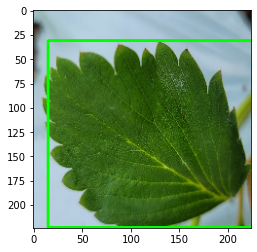

In [88]:
import cv2
i = 47
img = image[i]
cv2.rectangle(img,
              (int(json['x'][i]),int(json['y'][i])),
              (int((json['x'][i]+json['w'][i])),int((json['y'][i]+json['h'][i]))),
              (0,255,0),
              2
)
plt.imshow(img)
plt.show()

In [ ]:
# visualize bbox
plt.figure(figsize=(7,7))
# points = sample_json['annotations']['bbox'][0]
# part_points = sample_json['annotations']['part']
# img = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

cv2.rectangle(#<---- 잎파리 박스 
    img,
    (int(points['x']), int(points['y'])),
    (int((points['x']+points['w'])), int((points['y']+points['h']))),
    (0, 255, 0),
    2
)
for part_point in part_points: #<---- 병충 라벨링
    point = part_point
    cv2.rectangle(
        img,
        (int(point['x']), int(point['y'])),
        (int((point['x']+point['w'])), int((point['y']+point['h']))),
        (255, 0, 0),
        1
    )
plt.imshow(img)
plt.show()

# 전처리 

## 이미지 

normalization 

In [7]:
normalized_imag = image/255.

## json 

In [8]:
json.drop(columns = json.columns[0],inplace=True)

In [9]:
json.head()

,image_num,crop,disease,risk,bbox,part,x,y,h,w
0,24807,4,00,0,"[81.67619270833333, 21.942856770833334, 461.40...",[],26.826198,9.600000,201.866656,164.360506
1,46514,4,00,0,"[141.90476041666668, 38.09523958333333, 457.14...",[],46.608015,16.666667,200.000008,159.530807
2,36465,4,00,0,"[150.47620833333335, 40.00000260416667, 428.57...",[],49.423271,17.500001,187.500013,146.080160
3,42651,1,00,0,"[111.29904513888889, 152.71618412990196, 352.2...",[],36.555698,66.813331,154.108973,108.637096
4,42549,1,00,0,"[135.2371875, 0.0, 468.576875, 432.386]",[],44.418079,0.000000,205.002383,142.015343


bbox 분리 

In [10]:
label = np.array(json[['x','y','h','w']])

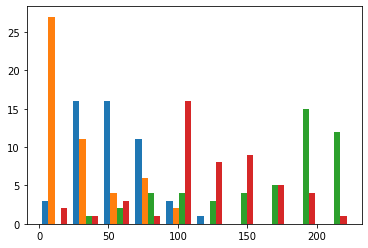

223.74821875

In [11]:
plt.hist(label)
plt.show()
np.max(label)

crop 정답 

In [12]:
crop = np.array(json['crop'])

crop range 변경 1-6 ~ 0-5 

In [13]:
for i in range(6):
  crop[crop==i+1]=i

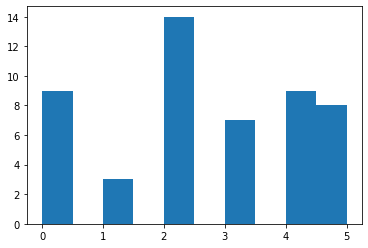

In [14]:
plt.hist(crop)
plt.show()

# train - test data 

In [15]:
print(label.shape,image.shape,crop.shape)

(50, 4) (50, 224, 224, 3) (50,)


In [16]:
from sklearn.model_selection import train_test_split
train_image_x,test_image_x,train_y,test_y = train_test_split(image,crop,shuffle=False)

In [17]:
train_label_x = label[:37]
test_label_x = label[37:]

#모델 1 
- image, bbox 라벨 이용 해서 crop 분류하기 

In [36]:
# import the necessary packages
from tensorflow.keras import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.applications import resnet50
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Bidirectional, LSTM, GRU

In [20]:
train_image_x = resnet50.preprocess_input(train_image_x)
train_label_x = resnet50.preprocess_input(train_label_x)
test_image_x = resnet50.preprocess_input(test_image_x)
test_label_x = resnet50.preprocess_input(test_label_x)

In [ ]:
conv_layers = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False
# model.add(conv_layers)

In [47]:
#label 데이터 파트 
label_input = Input((4,1))
x = GRU(128)(label_input)
x = Flatten()(x)
x = Dense(10, activation ='relu')(label_input)
label_output = Dense(4 ,activation='linear')(x)

#iamge 데이터 파트 
image_input = Input((224,224,3))
x = conv_layers(image_input)
x = Flatten()(x)
x = Dense(10, activation='relu')(x)
image_output = Dense(10, activation='linear')(x)

#헤드 결합 
combined_input = concatenate([label_output,image_output])
x= Dense(4, activation = 'relu')(combined_input)
output = Dense(6,activation = 'softmax')(x)

combined_model = Model([label_input,image_input],output)

In [ ]:
image_input = Input((224,224,3))
x = conv_layers(image_input)
x = Flatten()(x)
x = Dense(10, activation='relu')(x)
image_output = Dense(10, activation='linear')(x)

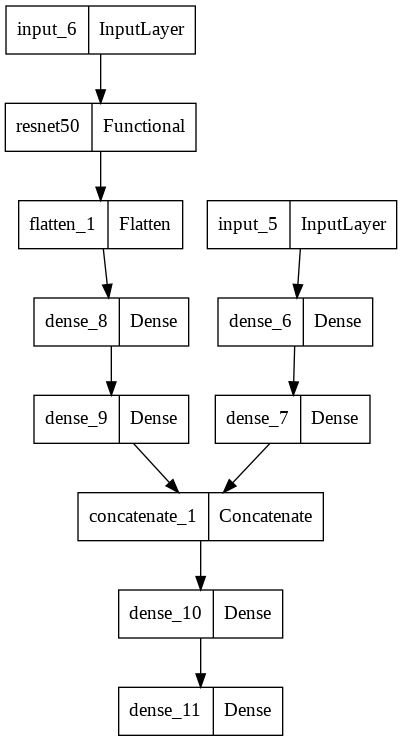

In [31]:
#모델 설계 구조 
import tensorflow 
tensorflow.keras.utils.plot_model(combined_model)

In [32]:
#학습 방식은 동일 
combined_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",metrics = ['accuracy'])
combined_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 7, 7, 2048)   23587712    ['input_6[0][0]']                
                                                                                                  
 input_5 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 flatten_1 (Flatten)            (None, 100352)       0           ['resnet50[0][0]']         

In [33]:
history = combined_model.fit([train_label_x,train_image_x], train_y, epochs=1000, verbose=1, batch_size=128,validation_split=0.2)

Epoch 1/1000
1/1 [==============================] - 6s 6s/step - loss: 3.6348 - accuracy: 0.1379 - val_loss: 1.5832 - val_accuracy: 0.6250
Epoch 2/1000
1/1 [==============================] - 0s 107ms/step - loss: 1.7376 - accuracy: 0.2414 - val_loss: 1.5679 - val_accuracy: 0.6250
Epoch 3/1000
1/1 [==============================] - 0s 114ms/step - loss: 1.7374 - accuracy: 0.2759 - val_loss: 1.5681 - val_accuracy: 0.6250
Epoch 4/1000
1/1 [==============================] - 0s 113ms/step - loss: 2.2005 - accuracy: 0.2069 - val_loss: 1.5672 - val_accuracy: 0.6250
Epoch 5/1000
1/1 [==============================] - 0s 111ms/step - loss: 1.7274 - accuracy: 0.2759 - val_loss: 1.5669 - val_accuracy: 0.6250
Epoch 6/1000
1/1 [==============================] - 0s 109ms/step - loss: 1.7286 - accuracy: 0.2759 - val_loss: 1.5668 - val_accuracy: 0.6250
Epoch 7/1000
1/1 [==============================] - 0s 112ms/step - loss: 1.7238 - accuracy: 0.2759 - val_loss: 1.5667 - val_accuracy: 0.6250
Epoch 8/1

In [1]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

NameError: ignored